# Train DNN


## Who is Running?

In [19]:
#Matheus  
project_root = "/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Projeto_Final_DL"
#Gabi
#Jean
#Sandra

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## General Parâmeters

In [20]:
# Geneal parameters used on this notebook
study_case_name = "Pulsatrix_koeniswaldiana" #@param {type:"string"}
only_focus = True #@param {type:"boolean"}
strategy = "Flatten_DNN" #@param ["Flatten_DNN", "TabNet"]{type:"string"}

Fixed Parameters

In [21]:
# Geneal parameters used on this notebook
study_cases_root_folder = project_root+"/Data/Study_Cases"
results_folder = project_root + "/Results"
model_weights_folder_path = project_root + "/Data/Model_Weights"
base_txt_files_path = project_root + "/Data/Standarized_Brazil_Data/TXT_Aux_Files"
base_csv_files_path = project_root + "/Data/Standarized_Brazil_Data/CSV_Aux_Files"
base_numpy_files_path = project_root + "/Data/Standarized_Brazil_Data/Numpy_Aux_Files"
stacked_environment_rasters_array_path = f"{base_numpy_files_path}/stacked_environment_rasters_array.npy" 
mean_std_path = f"{base_csv_files_path}/brazil_vars_mean_std.csv"
land_reference_path = project_root+ "/Data/Standarized_Brazil_Data/Base_Rasters/brazilian_mask_standarized.tif"



## Installs

In [22]:
! pip install geopandas --quiet
! pip install rasterio --quiet

  ## Retrieving aux Classes

In [23]:
!wget https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/utils.py
!wget https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/raster_utils.py


--2021-01-13 11:59:19--  https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799 [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]     799  --.-KB/s    in 0s      

2021-01-13 11:59:19 (59.1 MB/s) - ‘utils.py.1’ saved [799/799]

--2021-01-13 11:59:19--  https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/raster_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49

In [24]:
from utils import Utils
from raster_utils import Raster_Utils

raster_utils = Raster_Utils()
utils_methods = Utils()

## Getting Specie Study Data

In [25]:
import pandas as pd
import os
study_case_path =  os.path.join(study_cases_root_folder,study_case_name +'.csv')
study_information_df = pd.read_csv(study_case_path)
study_information_df

,GBIF_ID,Species_Name,Study_Focus
0,2497885,Pulsatrix koeniswaldiana,True


In [26]:
species_name = study_information_df[study_information_df['Study_Focus'] ==True]['Species_Name'][0]
taxonKey = study_information_df[study_information_df['Study_Focus'] ==True]['GBIF_ID'][0]
species_name_string = species_name.replace(" ","_")
print(f"species_name: {species_name} \ntaxonKey: {taxonKey} \nspecies_name_string: {species_name_string} \n ")

species_name: Pulsatrix koeniswaldiana 
taxonKey: 2497885 
species_name_string: Pulsatrix_koeniswaldiana 
 


In [27]:
list_raster_files = open(f"{base_txt_files_path}/list_raster_files.txt", 'r').read().splitlines()
list_names_raster = open(f"{base_txt_files_path}/list_names_raster.txt", 'r').read().splitlines()

## Imports

In [28]:
import pandas as pd
import numpy as np
import os
import keras
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
import matplotlib
import matplotlib.pyplot as plt

## creating custom cmap for plottings

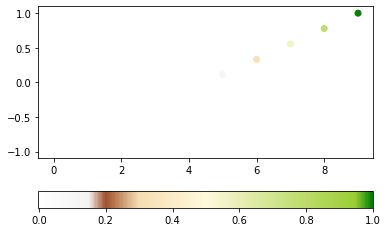

<Figure size 432x288 with 0 Axes>

In [29]:
#create colormap for maps
norm = matplotlib.colors.Normalize(-0.001,1)
colors = [[norm(-0.001), "white"],
          [norm(0.15),"0.95"],
          [norm(0.2),"sienna"],
          [norm(0.3),"wheat"],
          [norm(0.5),"cornsilk"],
          [norm(0.95),"yellowgreen"],
          [norm(1.0),"green"]]
        
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
custom_cmap.set_bad(color="white")

fig, ax=plt.subplots()
x = np.arange(10)
y = np.linspace(-1,1,10)
sc = ax.scatter(x,y, c=y, norm=norm, cmap=custom_cmap)
fig.colorbar(sc, orientation="horizontal")
plt.show()
plt.clf()

## Getting Data from the Brazilian Territory

In [30]:
land_reference,_,xgrid, ygrid ,_,_=  raster_utils.get_raster_infos(land_reference_path)
stacked_raster_coverages = utils_methods.retrieve_data_from_np_array(stacked_environment_rasters_array_path)
idx = np.where(land_reference == raster_utils.positive_mask_val) # Coords X and Y in two tuples where condition matchs (array(),array())
brazil_vars_mean_std_df = pd.read_csv(mean_std_path)
mean_vars = np.float32(brazil_vars_mean_std_df['mean'].to_numpy())
std_vars = np.float32(brazil_vars_mean_std_df['std'].to_numpy())

Reading raster brazilian_mask_standarized.tif


In [31]:
stacked_raster_coverages_shape = stacked_raster_coverages.shape
raster_coverages_land = stacked_raster_coverages[:, idx[0], idx[1]].T
for k in range(raster_coverages_land.shape[1]):
  raster_coverages_land[:,k][raster_coverages_land[:,k]<= raster_utils.no_data_val] = mean_vars[k]
del stacked_raster_coverages

scaled_coverages_land = (raster_coverages_land - mean_vars) / std_vars
scaled_coverages_land[np.isnan(scaled_coverages_land)] = 0
del raster_coverages_land

## Load the model

In [32]:
json_file = open(f"{model_weights_folder_path}/{species_name_string}/{strategy}/{species_name_string}_model.json",'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

#load weights into new model
loaded_model.load_weights(f"{model_weights_folder_path}/{species_name_string}/{strategy}/{species_name_string}_model.h5")

#compile model
#loaded_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
#loaded_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy','AUC'])

In [33]:
# global_pred = loaded_model.predict(x=scaled_coverages_land,batch_size=10,verbose=0) ###predict output value (N,38)
global_pred = loaded_model.predict(x=scaled_coverages_land) ###predict output value (N,38)

del scaled_coverages_land

## Assign predictions to brazilian territory using the mask

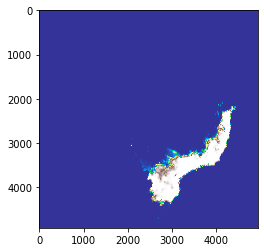

In [34]:
Z= np.ones((stacked_raster_coverages_shape[1], stacked_raster_coverages_shape[2]), dtype=np.float32)
# Z *= global_pred.min()
# Z *=-1 #This will be necessary to set points outside map to the minimum
Z*= raster_utils.no_data_val #This will be necessary to set points outside map to the minimum
Z[idx[0], idx[1]] = global_pred.ravel()
Z[Z == raster_utils.no_data_val] = -0.001


plt.imshow(Z, cmap='terrain')
plt.show()

## Plotting map with the distributions

No handles with labels found to put in legend.


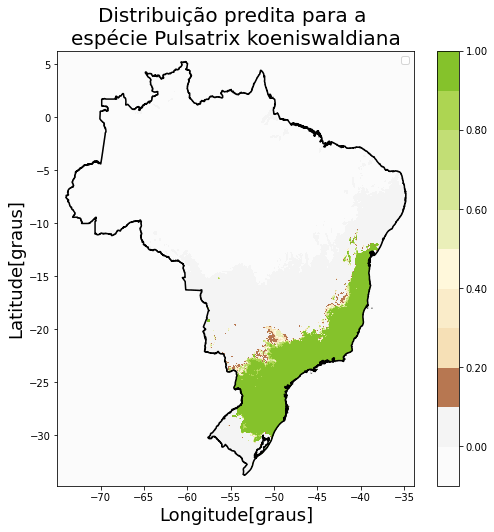

<Figure size 432x288 with 0 Axes>

In [35]:
X, Y = xgrid, ygrid[::-1]

plt.figure(figsize=(8,8))

# Setting titles and labels        
plt.title(f'Distribuição predita para a \nespécie {species_name}',fontsize=20)
plt.ylabel('Latitude[graus]',fontsize=18)
plt.xlabel('Longitude[graus]',fontsize=18)

# Plot country map
plt.contour(X, Y, land_reference,
                    levels=[10], colors="k",
                    linestyles="solid")


# print('levels: ',levels)
plt.contourf(X, Y, Z, levels=10, cmap=custom_cmap)
plt.colorbar(format='%.2f')

# Saving results
plt.legend(loc="upper right")
output_folder = os.path.join(results_folder,species_name)
output_folder = os.path.join(output_folder,strategy)
utils_methods.create_folder_structure(output_folder)
plt.savefig(f'{output_folder}/land_map_final_prediction_{strategy}_strategy.png')
plt.show() 
plt.clf()